# Project 1: Movie Budget Analysis

The purpose of this analysis is to better understand the movie industry. We are specifically interested in looking at what movies or types of movies should be made by a new studio/company trying to get into the film industry. We are therefore looking at films from the past 9 years (2010-2018) with the hopes of identifying key trends to allow a nascent production company become successful.

### Import Necessary Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
import as_functions as asf
%matplotlib inline
sns.set_palette(sns.color_palette('muted'))
sns.set_style("darkgrid")

### Import Datasets

In [2]:
bom = pd.read_csv("data/bom.movie_gross.csv.gz")
imdb_names = pd.read_csv("data/imdb.name.basics.csv.gz")
imdb_title_basics = pd.read_csv("data/imdb.title.basics.csv.gz")
imdb_title_ratings = pd.read_csv("data/imdb.title.ratings.csv.gz")
tmdb = pd.read_csv("data/tmdb.movies.csv.gz")
tn_movie_budgets = pd.read_csv("data/tn.movie_budgets.csv.gz", sep=',')
tppm = pd.read_csv('data/title_people_profs_merge.csv')
tppm.drop('Unnamed: 0', axis=1, inplace=True)

## Cleaning Data

In [ ]:
inner_bom_tmdb = bom.merge(tmdb, left_on='title', right_on='title')
imdb_title_basics.set_index('tconst', inplace=True)
imdb_movie_data = imdb_title_basics.merge(imdb_title_ratings, left_index=True, right_on='tconst')
inner_bom_imdb = bom.merge(imdb_movie_data, left_on='title', right_on='primary_title')
inner_bom_imdb.set_index('tconst', inplace=True)

OHE_genres One-Hot Encodes the genre column. The genre column is first converted into a list of genres that 
describes a movie. We then stack this dataframe to join with the original dataframe. This leaves us with a 
series in which each row is a genre for a given movie. We turn this series into dummy variables with get_dummies
and sum along the columns for each index to get a single row telling us which genres the movie belongs to. 
This genre series is then merged with the original dataset.  

In [ ]:
inner_bom_imdb = asf.OHE_genres(inner_bom_imdb)

### Fixing Movie Gross Problems

When the foreign gross data was scraped, any amount over $1 billion was instead saved in millions, in a string.
I had to manually go through and correct these values.

In [34]:
inner_bom_imdb.loc[inner_bom_imdb.foreign_gross == '1,019.4','foreign_gross'] = 1_019_440_000
inner_bom_imdb.loc[inner_bom_imdb.foreign_gross == '1,010.0', 'foreign_gross'] = 1_010_000_000
inner_bom_imdb.loc[inner_bom_imdb.foreign_gross == '1,369.5','foreign_gross'] = 1_369_500_000
inner_bom_imdb.loc[inner_bom_imdb.foreign_gross == '1,163.0','foreign_gross'] = 1_163_000_000

In [50]:
# Create a column for total gross for each movie
inner_bom_imdb['total_gross'] = inner_bom_imdb['domestic_gross'] + inner_bom_imdb.foreign_gross.astype(float).fillna(0)



Some movies in the budget dataset had no domestic/international release (Such as Netflix originals).
We elect to remove these from the dataset because they contain no information on the profitability of a given 
movie.

In [ ]:
null_box_office = inner_bom_imdb[inner_bom_imdb.domestic_gross.isna()].index
inner_bom_imdb = inner_bom_imdb.drop(null_box_office)

### Making Each Movie in names a row

In [38]:
names = imdb_names.copy()
names2 = imdb_names.copy()

In the next two cells, we perform a similar act to an actor's known films and professions as we did with movie genre. We will effectively melt the known films and professions into a column. Each of these cells will create a new dataframe in which each row corresponds to an actor's known movie or profession.

In [ ]:
names['kft'] = names.known_for_titles.str.split(',')
s = names.apply(lambda x: pd.Series(x['kft']), axis=1).stack().reset_index(level=1, drop=True)
s.name = "Known_Movies"
names_movies = names.join(s).drop(['nconst', 'birth_year',
                                   'death_year', 
                                   'known_for_titles', 'kft', 'primary_profession'], axis=1)

In [ ]:
names2['profs'] = names2.primary_profession.str.split(',')
s = names2.apply(lambda x: pd.Series(x['profs']), 
                                         axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Professions'
names_profs = names2.join(s).copy()
profs_dummies = pd.get_dummies(names_profs.Professions).sum(level=0)
names_profs = names_profs.join(profs_dummies)
names_profs.drop(['nconst', 'birth_year', 'death_year', 'known_for_titles',
                  'primary_profession', 'Professions', 'profs'], axis=1, inplace=True)
names_profs.drop_duplicates(inplace=True)

### Merge People and Movies Dataframe

We want to now merge our people and professions dataframe with the BoxOfficeMojo/IMDB dataframe.

In [ ]:
titles_people_merge = inner_bom_imdb.merge(names_movies, left_index=True, right_index=True)
titles_people_profs_merge = titles_people_merge.merge(names_profs, left_on='primary_name', right_on='primary_name')
tppm = titles_people_profs_merge.copy()

## Exploring the Data

Because our TPPM dataframe has a row for every actor, writer, producer, etc. in a movie, we want to drop duplicate rows that correspond to the same movie. We identify this according to title and start_year. We also are interested in only the first 35 columns, because the other columns correspond to roles of different people.

We drop movie studio HC because they have one film, which happened to gross ~$870 million, which throws off some of our analysis.

We also limit some of our analysis to only looking at the 200 top grossing movies from 2010-2018 because we are looking for trends in highly successful films.

In [17]:
movies = tppm.drop_duplicates(subset=['title', 'start_year']).iloc[:, :34].copy()
movies = movies.drop(movies[movies.studio == 'HC'].index)
movies_sorted = movies.sort_values(by='total_gross', ascending=False)[:200]
top_10_studios = movies.groupby('studio').sum()['total_gross'].sort_values(ascending=False)
top_10_studios_mean = movies.groupby('studio').mean()['total_gross'].sort_values(ascending=False)

In [22]:
pd.DataFrame([top_10_studios, top_10_studios_mean], index=['Total_Gross', 'Average_Total_Gross']).T[:10]

,Total_Gross,Average_Total_Gross
BV,4.099715e+10,4.361399e+08
Uni.,3.302841e+10,2.246830e+08
Fox,3.030797e+10,2.212260e+08
WB,2.609310e+10,2.192698e+08
Sony,1.808166e+10,2.078351e+08
Par.,1.803928e+10,2.026885e+08
WB (NL),1.080940e+10,2.119490e+08
LGF,8.239376e+09,9.257726e+07
P/DW,5.076500e+09,5.076500e+08
LG/S,4.012724e+09,1.146493e+08


Text(0.5,1,'Total Gross by Studio')

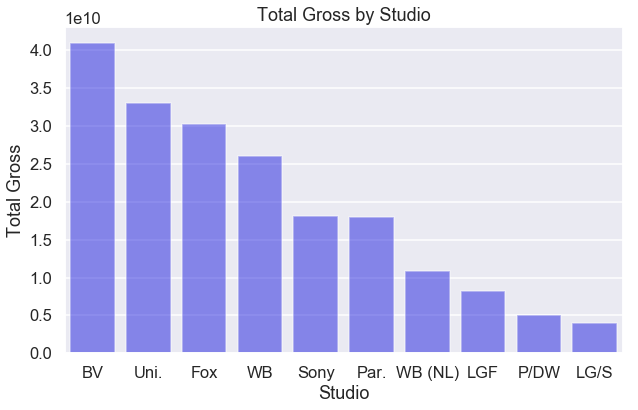

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_studios[:10].index, y=top_10_studios[:10], color='b', alpha=0.5)
plt.xlabel('Studio')
plt.ylabel("Total Gross")
plt.title("Total Gross by Studio")

Buena Vista stands alone as the highest-grossing film studio. Universal and Fox have also done very well recently.

Text(0.5,1,'Average Movie Gross by Studio')

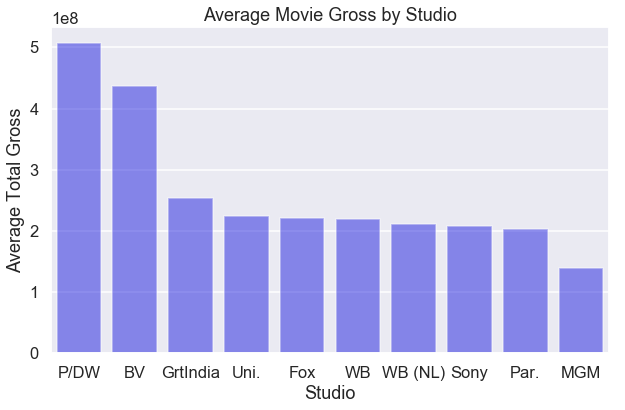

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_studios_mean[:10].index, y=top_10_studios_mean[:10], color='b', alpha=0.5)
plt.xlabel("Studio")
plt.ylabel("Average Total Gross")
plt.title("Average Movie Gross by Studio")

Paramount/Dreamworks and Buena Vista stand alone as the highest grossing studios on a per-film basis. If we could consult or take people from these companies, we would be setting ourselves up for success.

### Examining some of the most popular people

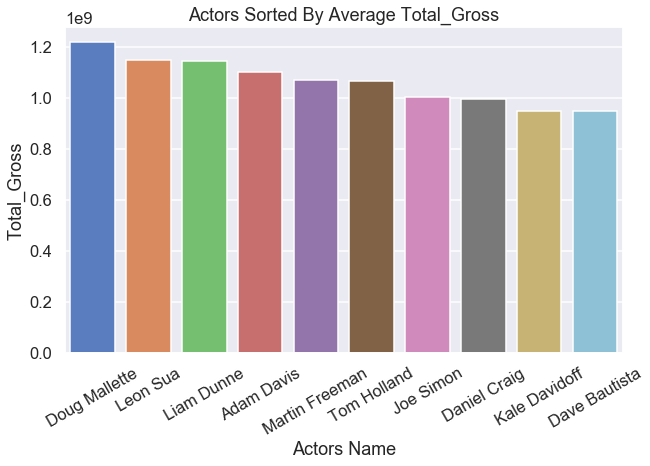

In [8]:
asf.plot_most_popular_people(tppm, 'actor', 'total_gross')

A lot of these most popular actors are not household names. Looking at their IMDB pages, we see that they are all associated with a series of major blockbusters, such as Marvel movies, Lord of the Rings/The Hobbit, or James Bond. We would therefore recommend creating a series of films.

### Genres of Movies

In [6]:
movies_sorted.iloc[:,11:33].sum()

Action         112
Adventure      138
Animation       51
Biography        7
Comedy          63
Crime           10
Documentary      6
Drama           39
Family          11
Fantasy         26
History          3
Horror           8
Music            2
Musical          2
Mystery          8
News             0
Romance          4
Sci-Fi          47
Sport            2
Thriller        26
War              0
Western          1
dtype: int64

Action and Adventure are by far the most popular genres of films, according to the top 200 grossing films from 2010-2018. 

### Grouping by Genre

The following cell is used to convert the movies genre column into something we can more easily groupby. Because films can have multiple genres, we cannot directly groupby on it. We therefore must do a similar thing to what we did before, where we create multiple rows for each movie, one row for each of its genres. We can then groupby on this column, and each movie will be counted in each of its respective genres. 

In [9]:
movie_genres = movies_sorted.iloc[:,11:33].stack().reset_index(level=1)
movie_genres.name = 'stacked_genres'
movies_with_genres = movies_sorted.join(movie_genres)
movies_with_genres = movies_with_genres[movies_with_genres[0] == 1]

Text(0.5,1,'Total Gross by Genre')

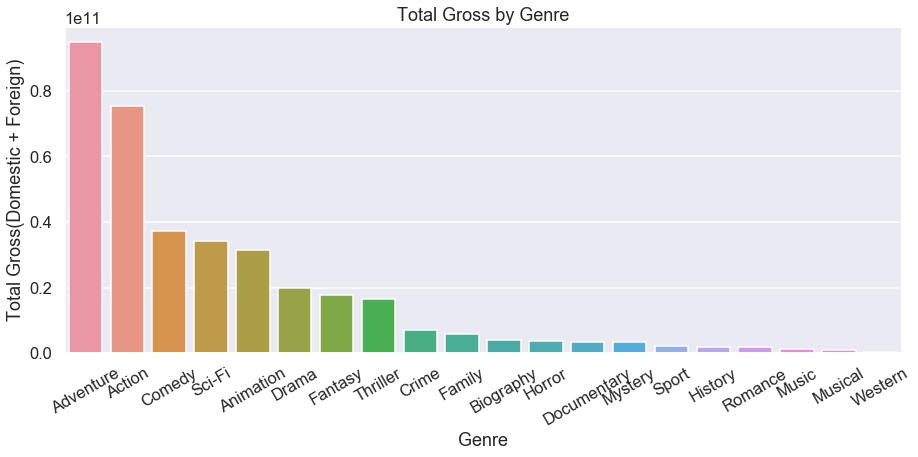

In [10]:
top_grossing_genres = movies_with_genres.groupby('level_1')['total_gross'].sum().sort_values(ascending=False)
plt.figure(figsize=(15,6))
sns.barplot(x=top_grossing_genres.index, y=top_grossing_genres)
plt.xticks(rotation=30)
plt.xlabel('Genre')
plt.ylabel('Total Gross(Domestic + Foreign)')
plt.title('Total Gross by Genre')

Not surprisingly, Adventure and Action films bring in the most money as a whole. It seems that despite the large number of films in these genres, they still appear to do well for themselves.

We will now look at the per-film grossing of films in the 5 best-grossing genres.

Text(0.5,1,'Total Gross by Genre')

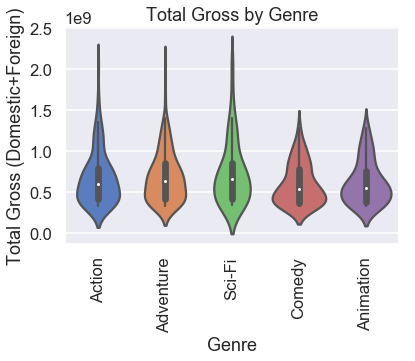

In [12]:
movies_with_genres_aasca = movies_with_genres[movies_with_genres['level_1'].isin(['Adventure', 
                                                                                 'Action', 
                                                                                 'Sci-Fi',
                                                                                 'Comedy',
                                                                                 'Animation'])]
x = sns.violinplot(x='level_1', y='total_gross', data=movies_with_genres_aasca, dpi=1200)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Total Gross (Domestic+Foreign)')
plt.title('Total Gross by Genre')

Looking at the genres on a per-movie basis, we see that the three genres of Action, Adventure, and Sci-Fi each perform very similarly to one another, with comedy and animation performing similar to one another, albeit selling less than the top 3 genres. This may be surprising considering the saturation of Action and Adventure films in the market, but it appears that despite the large number of films people still want to see many of them. 

### Add budget data

In [13]:
tn2 = tn_movie_budgets.copy()
tn2[['production_budget',
     'domestic_gross',
     'worldwide_gross']] = tn2[['production_budget',
                                'domestic_gross',
                                'worldwide_gross']].applymap(lambda x: x.replace("$", '').replace(',', '')).astype(float)
               
tn2.drop(tn2[tn2.worldwide_gross == 0].index, inplace=True)
tn2[['log_prod', 'log_wwg']] = tn2[['production_budget', 'worldwide_gross']].applymap(np.log10)
tn2['gross_profit'] = tn2['worldwide_gross'] - tn2['production_budget']



                                                                

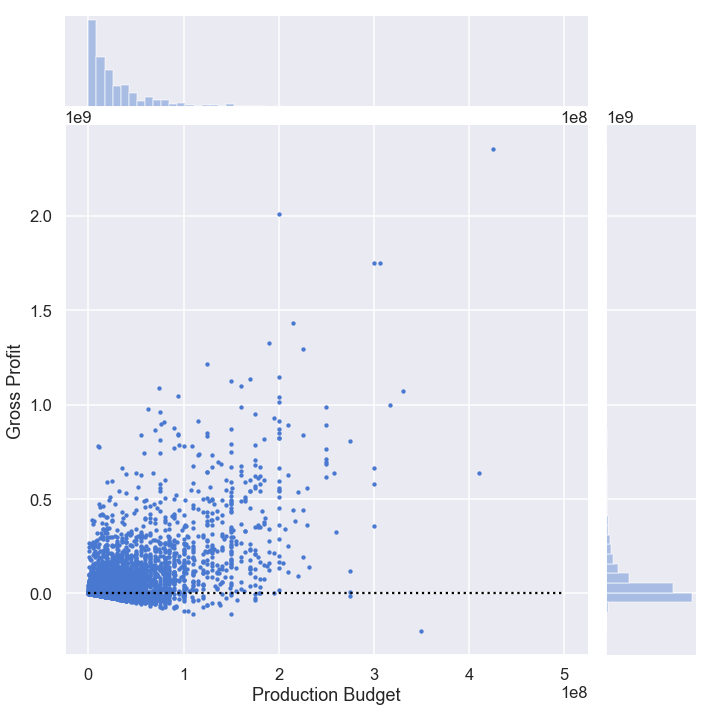

In [14]:
h = sns.jointplot(x='production_budget',
              y='gross_profit',
              data=tn2,
              height=10,
              s=8)
h.set_axis_labels("Production Budget", "Gross Profit")
h.ax_joint.plot([0,500_000_000], [0,0], ':k') 

The dotted line on the bottom separates films that lost money from thos that made a profit. The histogram on the right shows us that many films lose or make a small amount of money. However, notice that the more money is spent, the less likely the movie is to lose money.